In [4]:
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [5]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


In [7]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=base

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-base.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-base.o -o stencil2d-base.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-base.x' (lite-samples) ...OK


cp stencil2d-base.x stencil2d.x


In [21]:
%%bash
export OMP_NUM_THREADS=1
srun -n 24 ./stencil2d-base.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_mpi_openmp.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


## Validation

In [10]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

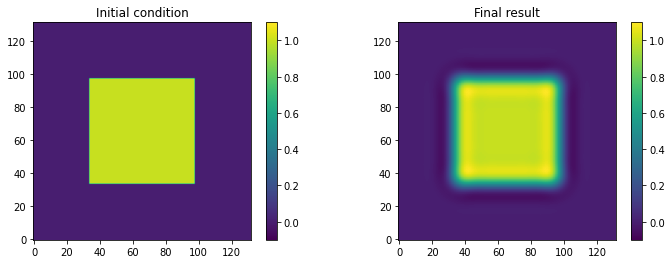

In [8]:
validate_results()